In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
plt.style.use('default')

import functools
import warnings

from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit


In [ ]:
def flatten(func):
    ''' Decorator to flatten function parameters '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        flat_args = [a if a is None else a.flatten() for a in args]
        return func(*flat_args, **kwargs)
    return helper

def validate_shape(func):
	''' Decorator to flatten all function input arrays, and ensure shapes are the same '''
	@functools.wraps(func)
	def helper(*args, **kwargs):
		flat     = [a.flatten() if hasattr(a, 'flatten') else a for a in args]
		flat_shp = [a.shape for a in flat if hasattr(a, 'shape')]
		orig_shp = [a.shape for a in args if hasattr(a, 'shape')]
		assert(all(flat_shp[0] == s for s in flat_shp)), f'Shapes mismatch in {func.__name__}: {orig_shp}'
		return func(*flat, **kwargs)
	return helper

def only_finite(func):
	''' Decorator to remove samples which are nan in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(np.isfinite(stacked), 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper

def only_valid(func):
    ''' Decorator to remove all elements having a nan in any array '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        assert(all([len(a.shape) == 1 for a in args]))
        stacked = np.vstack(args)
        valid = np.all(np.isfinite(stacked), 0)
        return func(*stacked[:, valid], **kwargs)
    return helper

def only_positive(func):
	''' Decorator to remove samples which are zero/negative in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(stacked > 0, 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper


def label(name):
    ''' Label a function for when it's printed '''
    def helper(f):
        f.__name__ = name
        return f
    return helper

@only_finite
@label('RMSE')
def rmse(y, y_hat):
	''' Root Mean Squared Error '''
	return np.mean((y - y_hat) ** 2) ** .5


@only_finite
@only_positive
@label('RMSLE')
def rmsle(y, y_hat):
	''' Root Mean Squared Logarithmic Error '''
	return np.mean(np.abs(np.log(y) - np.log(y_hat)) ** 2) ** 0.5


@only_finite
@label('NRMSE')
def nrmse(y, y_hat):
	''' Normalized Root Mean Squared Error '''
	return ((y - y_hat) ** 2).mean() ** .5 / y.mean()

@only_finite
@only_positive
@label('R^2')
def r_squared(y, y_hat):
	''' Logarithmic R^2 '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return r_value**2

@label('<=0')
@flatten
@only_valid
def leqz(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return (y2 <= 0).sum()


@label('<=0|NaN')
@flatten
def leqznan(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return np.logical_or(np.isnan(y2), y2 <= 0).sum()

@label('MAD')
@flatten
@only_valid
def MAD(y1, y2):
    ''' Mean Absolute Error '''
    i  = np.logical_and(y1 > 0, y2 > 0)
    y1 = np.log10(y1[i])
    y2 = np.log10(y2[i])
    i  = np.logical_and(np.isfinite(y1), np.isfinite(y2))
    y1 = y1[i]
    y2 = y2[i]
    return 10**np.mean(np.abs(y1 - y2))-1

@only_finite
@label('MdAPE')
def mape(y, y_hat):
	''' Mean Absolute Percentage Error '''
	return 100 * np.mean(np.abs((y - y_hat) / y))

@only_finite
@only_positive
@label('MSA')
def msa(y, y_hat):
	''' Mean Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.mean(np.abs(np.log(y_hat / y)))) - 1)


@only_finite
@only_positive
@label('MdSA')
def mdsa(y, y_hat):
	''' Median Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.median(np.abs(np.log(y_hat / y)))) - 1)

@only_finite
@only_positive
@label('SSPB')
def sspb(y, y_hat):
	''' Symmetric Signed Percentage Bias '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	M = np.median( np.log(y_hat / y) )
	return 100 * np.sign(M) * (np.exp(np.abs(M)) - 1)


@only_finite
@label('Bias')
def bias(y, y_hat):
	''' Mean Bias '''
	return np.mean(y_hat - y)

@only_finite
@only_positive
@label('Slope')
def slope(y, y_hat):
	''' Logarithmic slope '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return slope_


@only_finite
@only_positive
@label('Intercept')
def intercept(y, y_hat):
	''' Locarithmic intercept '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return intercept_

@validate_shape
@label('MWR')
def mwr(y, y_hat, y_bench):
	'''
	Model Win Rate - Percent of samples in which model has a closer
	estimate than the benchmark.
		y: true, y_hat: model, y_bench: benchmark
	'''
	y_bench[y_bench < 0] = np.nan
	y_hat[y_hat < 0] = np.nan
	y[y < 0] = np.nan
	valid = np.logical_and(np.isfinite(y_hat), np.isfinite(y_bench))
	diff1 = np.abs(y[valid] - y_hat[valid])
	diff2 = np.abs(y[valid] - y_bench[valid])
	stats = np.zeros(len(y))
	stats[valid]  = diff1 < diff2
	stats[~np.isfinite(y_bench)] = 1
	stats[~np.isfinite(y_hat)] = 0
	return stats.sum() / np.isfinite(y).sum()

def performance(key, y1, y2, metrics=[rmse, slope, msa, rmsle, sspb, MAD, leqznan]):#[rmse, rmsle, mape, r_squared, bias, mae, leqznan, slope]):
    ''' Return a string containing performance using various metrics.
        y1 should be the true value, y2 the estimated value. '''
    return '%8s | %s' % (key, '   '.join([
            '%s: %6.3f' % (f.__name__, f(y1,y2)) for f in metrics]))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import os

# Define the path to the folder
folder_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

# List the contents of the folder
contents = os.listdir(folder_path)
print(contents)


['wd_test_set_org.csv', 'ood_test_set_org.csv', 'random_df_test_org.csv', 'ood_train_set_org.csv', 'wd_train_set_org.csv', 'filtered_df_2319.csv', 'random_df_train_org.csv']


In [ ]:
import pandas as pd

# Define the base path to the folder
base_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

# Load the three in situ scenarios
random_train_df = pd.read_csv(f'{base_path}/random_df_train_org.csv')
random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')

wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')

ood_train_df = pd.read_csv(f'{base_path}/ood_train_set_org.csv')
ood_test_df = pd.read_csv(f'{base_path}/ood_test_set_org.csv')

filtered_df = pd.read_csv(f'{base_path}/filtered_df_2319.csv')

<ipython-input-6-47b43289e051>:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')
<ipython-input-6-47b43289e051>:10: DtypeWarning: Columns (3,4,5,6,8,11,27,33,34,37,39,48,50,51,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
<ipython-input-6-47b43289e051>:11: DtypeWarning: Columns (4,5,34,37,39,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')
<ipython-input-6-47b43289e051>:13: DtypeWarning: Columns (3,6,8,11,27,33,34,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  ood_train_df = pd.read_csv(f'{base_path}/ood_train_set_org.csv')
<ipython-input-6-47b43289e051>:14: DtypeWarning: Columns (3,4,5,6,27,33,37,39,48,50,51,52,54,55,63) have

#1. Random split

# Step by step

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Select Rrs values in 5 nm steps
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
Rrs_data = filtered_df[rrs_columns].values

# Apply Robust scaling to Rrs values
scaler_rrs = RobustScaler()
Rrs_data_scaled = scaler_rrs.fit_transform(Rrs_data)

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_data = filtered_df[y_columns].values

# Split the dataset into training and test sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(Rrs_data_scaled, y_data, test_size=0.5, random_state=43)

#Apply log transformation to the target variables
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#Apply Min-Max scaling to log-transformed target variables
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_bnn_mcd(input_shape, hidden_units=50, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6):
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation, input_shape=input_shape, kernel_regularizer=l2(l2_reg)))
    for _ in range(n_layers - 1):
        model.add(Dropout(dropout_rate))
        model.add(Dense(hidden_units, activation=activation, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_size * 2, activation='linear'))
    return model

# def nll_loss(y_true, y_pred):
#     mean = y_pred[:, :6]
#     log_var = y_pred[:, 6:]
#     precision = tf.exp(-log_var)
#     return tf.reduce_mean(0.5 * (log_var + tf.square(y_true - mean) * precision) + 0.5 * np.log(2 * np.pi))

def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    var = tf.nn.softplus(y_pred[:, 6:])
    return tf.reduce_mean(0.5 * (tf.math.log(var) + (tf.square(y_true - mean) / var) + tf.math.log(2 * np.pi)))

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def train_bnn_mcd(model, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=nll_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

input_shape = (X_train.shape[1],)
model = build_bnn_mcd(input_shape=input_shape, hidden_units=100, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6)

model = train_bnn_mcd(model, X_train, y_train_scaled, epochs=1000, batch_size=32, learning_rate=0.001)



Epoch 1/1000
33/33 [==============================] - 2s 14ms/step - loss: 1.3119 - val_loss: 1.0757
Epoch 2/1000
33/33 [==============================] - 0s 5ms/step - loss: 7.6911 - val_loss: 1.0514
Epoch 3/1000
33/33 [==============================] - 0s 4ms/step - loss: 1.0328 - val_loss: 0.9037
Epoch 4/1000
33/33 [==============================] - 0s 5ms/step - loss: 1.0081 - val_loss: 0.8810
Epoch 5/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.9315 - val_loss: 0.8134
Epoch 6/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.8774 - val_loss: 0.8021
Epoch 7/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.8069 - val_loss: 0.7487
Epoch 8/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.7194 - val_loss: 0.5798
Epoch 9/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.6098 - val_loss: 0.4925
Epoch 10/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.6410 - val_loss: 0.451

In [ ]:
import numpy as np

def predict_with_uncertainty_old(model, X, scaler_y, n_samples=100, mc_samples=2000):

    """
    Generate predictions with uncertainty estimates using Monte Carlo Dropout.

    This function performs forward passes through the model with dropout enabled to
    generate multiple predictions, then calculates the aleatoric and epistemic uncertainties
    of the predictions. It also scales the predictions back to the original scale to faciliate comparisons.

    Parameters:
    model: keras.Model
        The neural network model with dropout layers.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
    n_samples: int, optional (default=100)
        Number of forward passes with dropout to generate prediction samples.
    mc_samples: int, optional (default=2000)
        Number of Monte Carlo samples for back-scaling of variances.

    Returns:
    mean_predictions: np.ndarray
        The mean predictions on the original scale.
    total_variance_mc: np.ndarray
        The total variance (aleatoric + epistemic) on the original scale.
    aleatoric_variance_mc: np.ndarray
        The aleatoric variance on the original scale.
    epistemic_variance_mc: np.ndarray
        The epistemic variance on the original scale.
    std_devs_mc: np.ndarray
        The standard deviations of the predictions on the original scale.
    """

    pred_samples = [model.predict(X, batch_size=32, verbose=0) for _ in range(n_samples)]
    pred_samples = np.array(pred_samples)

    means = pred_samples[:, :, :6]
    raw_variances = pred_samples[:, :, 6:]
    variances = tf.nn.softplus(raw_variances)

    mean_predictions_scaled = np.mean(means, axis=0)
    aleatoric_variance_scaled = np.mean(variances, axis=0)
    epistemic_variance_scaled = np.var(means, axis=0)
    total_variance_scaled = aleatoric_variance_scaled + epistemic_variance_scaled

    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions = np.exp(mean_predictions_log)

    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log->scaled scaling factor
    aleatoric_variance_log = aleatoric_variance_scaled * (scaling_factor ** 2)  # Uncertainty propagation for linear equations
    epistemic_variance_log = epistemic_variance_scaled * (scaling_factor ** 2)
    total_variance_log = total_variance_scaled * (scaling_factor ** 2)

    # Monte Carlo sampling for aleatoric variance
    aleatoric_samples = np.random.lognormal(mean_predictions_log, np.sqrt(aleatoric_variance_log), size=(mc_samples, *mean_predictions.shape))
    aleatoric_variance_mc = np.var(aleatoric_samples, axis=0)

    # Monte Carlo sampling for epistemic variance
    epistemic_samples = np.random.normal(mean_predictions, np.sqrt(epistemic_variance_log), size=(mc_samples, *mean_predictions.shape))
    epistemic_variance_mc = np.var(epistemic_samples, axis=0)

    total_variance_mc = aleatoric_variance_mc + epistemic_variance_mc
    std_devs_mc = np.sqrt(total_variance_mc)

    return mean_predictions, total_variance_mc, aleatoric_variance_mc, epistemic_variance_mc, std_devs_mc

mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty_old(model, X_test, scaler_y, n_samples=100, mc_samples=2000)


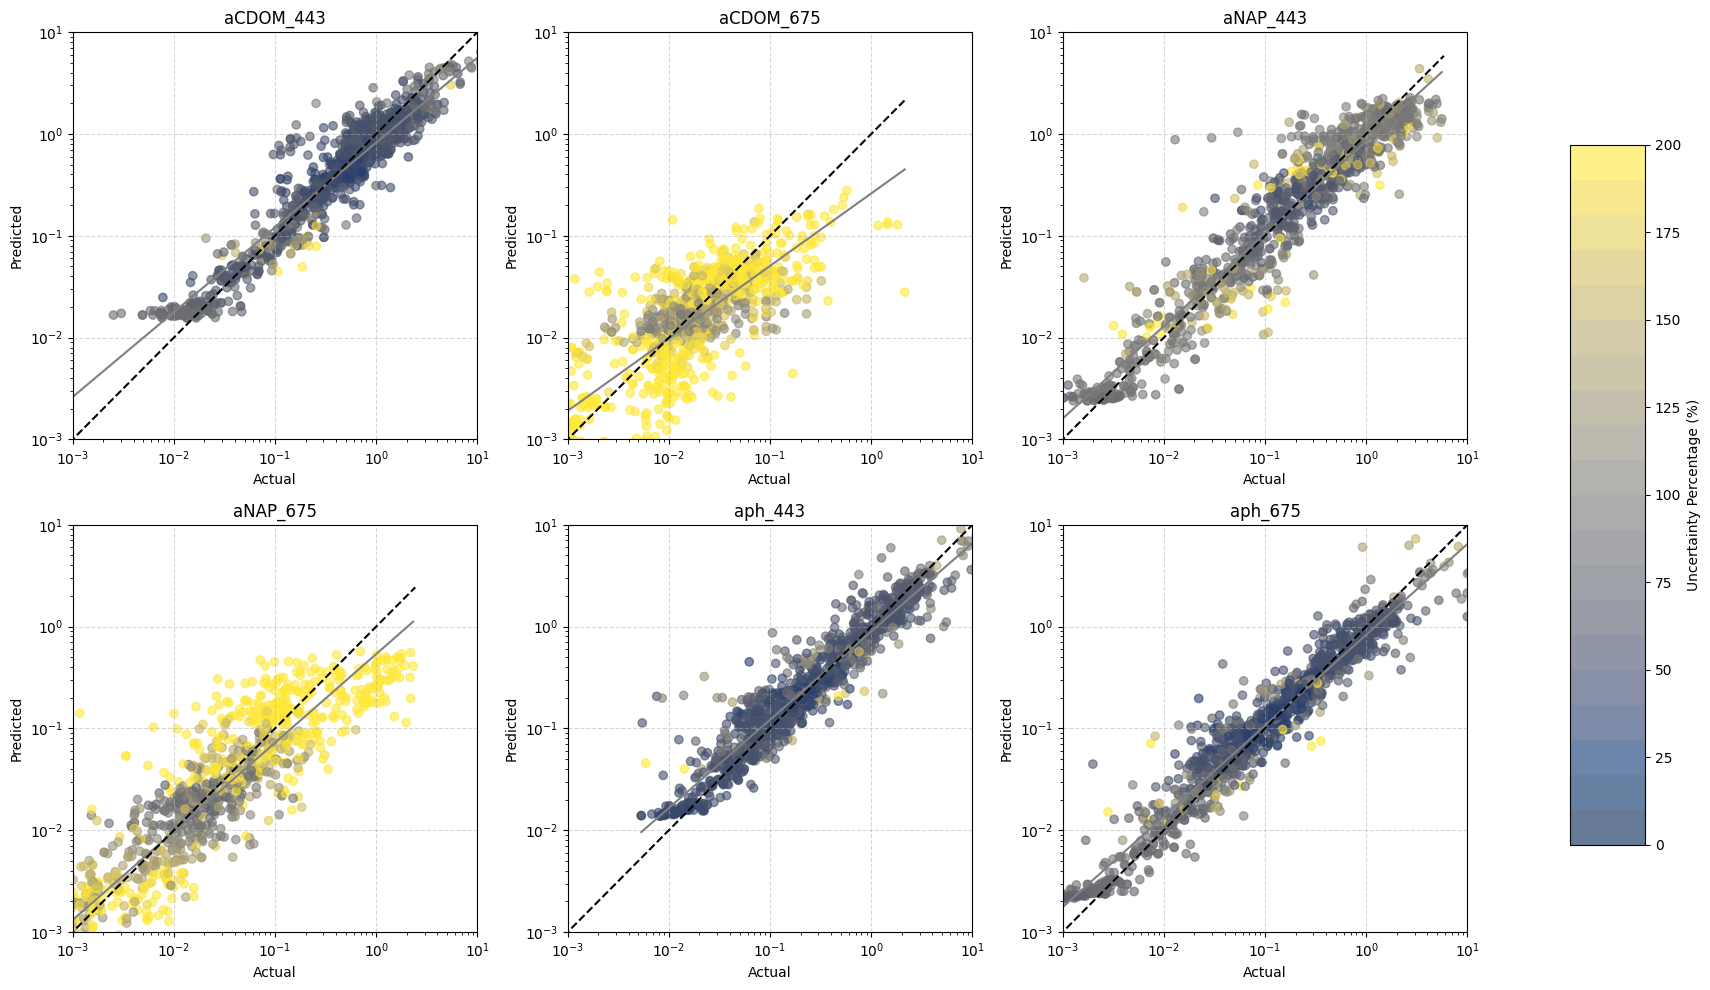

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap=plt.cm.cividis.resampled(20), norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [ ]:
def predict_with_uncertainty(model, X, scaler_y, n_samples=100):

    """
    Generate predictions with uncertainty estimates using Monte Carlo Dropout.

    This function performs forward passes through the model with dropout enabled to
    generate multiple predictions, scales these back to the original scale,
    then calculates the aleatoric and epistemic uncertainties of the predictions.

    Parameters:
    model: keras.Model
        The neural network model with dropout layers.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
        Note that this does not include log-scaling.
    n_samples: int, optional (default=100)
        Number of forward passes with dropout to generate prediction samples.

    Returns:
    mean_predictions: np.ndarray
        The mean predictions on the original scale.
    total_variance: np.ndarray
        The total variance (aleatoric + epistemic) on the original scale.
    aleatoric_variance: np.ndarray
        The aleatoric variance on the original scale.
    epistemic_variance: np.ndarray
        The epistemic variance on the original scale.
    std_devs: np.ndarray
        The standard deviations of the predictions on the original scale.
        Simply sqrt(total_variance), provided separately for convenience.
    """
    # Generate predictions in scaled space
    pred_samples = [model.predict(X, batch_size=32, verbose=0) for _ in range(n_samples)]
    pred_samples = np.array(pred_samples)

    mean_predictions_scaled = pred_samples[:, :, :6]
    raw_variances_scaled = pred_samples[:, :, 6:]
    variances_scaled = tf.nn.softplus(raw_variances_scaled)  # Ensure positive

    # Convert from scaled space to log space
    # The means need to be reshaped because sklearn expects a 2D array
    original_shape = mean_predictions_scaled.shape
    mean_predictions_scaled = mean_predictions_scaled.reshape(-1, 6)
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log-> scaled scaling factor
    variances_log = variances_scaled * (scaling_factor**2)  # Uncertainty propagation for linear equations

    # Convert from log space to the original space, i.e. actual IOPs in [m^-1]
    mean_predictions = np.exp(mean_predictions_log)  # Geometric mean / median
    variances = np.exp(2*mean_predictions_log + variances_log) * (np.exp(variances_log) - 1)  # Arithmetic variance

    # Calculate aleatoric and epistemic variance in the original space
    aleatoric_variance = np.mean(variances, axis=0)
    epistemic_variance = np.var(mean_predictions, axis=0)
    total_variance = aleatoric_variance + epistemic_variance
    std_devs = np.sqrt(total_variance)

    mean_predictions = np.mean(mean_predictions, axis=0)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100)


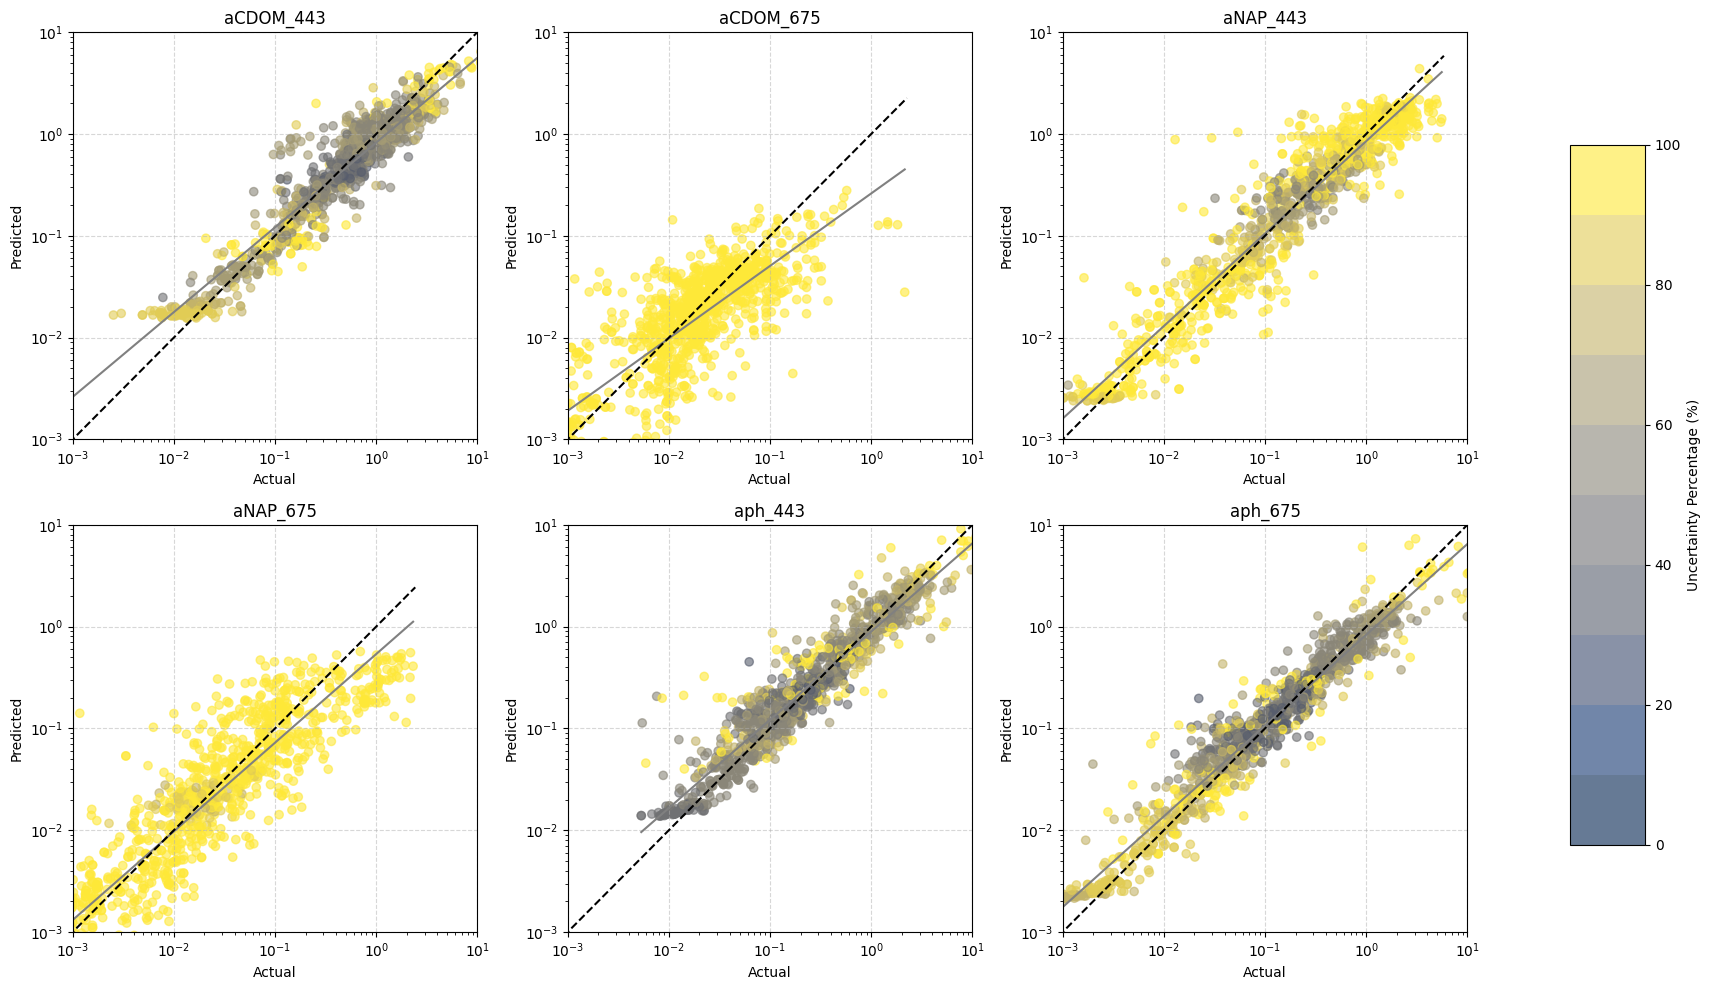

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=100)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap=plt.cm.cividis.resampled(10), norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [ ]:
# Testing: manually go through predict_with_uncertainty and check results
model, X, scaler, n_samples, mc_samples = model, X_test, scaler_y, 100, 2000

In [ ]:
pred_samples = [model.predict(X, batch_size=32, verbose=0) for _ in range(n_samples)]
pred_samples = np.array(pred_samples)

means = pred_samples[:, :, :6]
raw_variances = pred_samples[:, :, 6:]
variances = tf.nn.softplus(raw_variances)

In [ ]:
mean_predictions_scaled = means[0]
aleatoric_variance_scaled = variances[0]
#epistemic_variance_scaled = np.var(means, axis=0)
total_variance_scaled = aleatoric_variance_scaled #+ epistemic_variance_scaled

In [ ]:
mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log->scaled scaling factor
aleatoric_variance_log = aleatoric_variance_scaled * (scaling_factor ** 2)  # Uncertainty propagation for linear equations
#epistemic_variance_log = epistemic_variance_scaled * (scaling_factor ** 2)
total_variance_log = total_variance_scaled * (scaling_factor ** 2)

Median of MC samples: 1.0631
Arithmetic mean of MC samples: 1.2142
Arithmetic mean from prediction: 1.2318
Geometric mean of MC samples: 1.0628
Geometric mean (=Median) from prediction: 1.0787

Arithmetic standard deviation of MC samples: 0.6872
Arithmetic standard deviation from prediction: 0.6790
Geometric standard deviation factor of MC samples: 1.6715
Geometric standard deviation factor from prediction: 1.6739

Arithmetic variance of MC samples: 0.4723
Arithmetic variance from prediction: 0.4611


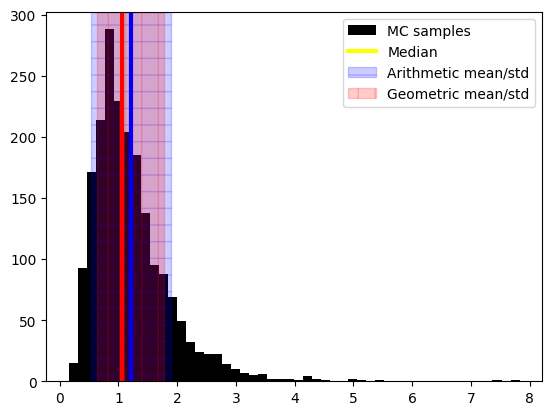

In [ ]:
# Monte Carlo sampling for aleatoric variance
aleatoric_samples = np.random.lognormal(mean_predictions_log, np.sqrt(aleatoric_variance_log), size=(mc_samples, *mean_predictions_log.shape))
aleatoric_variance_mc = np.var(aleatoric_samples, axis=0)

example = np.s_[..., 0, 0]
example_samples = aleatoric_samples[example]
muL = mean_predictions_log[example]
sigmaL = np.sqrt(aleatoric_variance_log[example])

# Compare statistics
from scipy.stats import gmean, gstd

median_from_samples = np.median(example_samples)
mean_from_samples = np.mean(example_samples)
gmean_from_samples = gmean(example_samples)

mean_from_prediction = np.exp(muL + 0.5*sigmaL**2)
gmean_from_prediction = np.exp(muL)

print(f"Median of MC samples: {median_from_samples:.4f}")
print(f"Arithmetic mean of MC samples: {mean_from_samples:.4f}")
print(f"Arithmetic mean from prediction: {mean_from_prediction:.4f}")
print(f"Geometric mean of MC samples: {gmean_from_samples:.4f}")
print(f"Geometric mean (=Median) from prediction: {gmean_from_prediction:.4f}")
print()

var_from_samples = np.var(example_samples)
std_from_samples = np.std(example_samples)
CI_from_samples = (mean_from_samples - std_from_samples, mean_from_samples + std_from_samples)

gstd_from_samples = gstd(example_samples)
gCI_from_samples = (gmean_from_samples / gstd_from_samples, gmean_from_samples * gstd_from_samples)
#gvar_from_samples = gstd_from_samples**2

var_from_prediction = np.exp(2*muL + sigmaL**2) * (np.exp(sigmaL**2) - 1)
std_from_prediction = np.sqrt(var_from_prediction)

gstd_from_prediction = np.exp(sigmaL)
#gvar_from_predictions = np.exp(sigmaL**2)
print(f"Arithmetic standard deviation of MC samples: {std_from_samples:.4f}")
print(f"Arithmetic standard deviation from prediction: {std_from_prediction:.4f}")
print(f"Geometric standard deviation factor of MC samples: {gstd_from_samples:.4f}")
print(f"Geometric standard deviation factor from prediction: {gstd_from_prediction:.4f}")
print()
print(f"Arithmetic variance of MC samples: {var_from_samples:.4f}")
print(f"Arithmetic variance from prediction: {var_from_prediction:.4f}")
#print(f"Geometric variance of MC samples: {gvar_from_samples:.4f}")
#print(f"Geometric variance from prediction: {gvar_from_predictions:.4f}")

# Plot samples for one IOP for one sample
plt.hist(example_samples, bins=50, color="black", label="MC samples")
plt.axvline(median_from_samples, lw=3, color="yellow", label="Median")

plt.axvline(mean_from_samples, lw=3, color="blue")
plt.axvspan(*CI_from_samples, color="blue", hatch="-", alpha=0.2, label="Arithmetic mean/std")

plt.axvline(gmean_from_samples, lw=3, color="red")
plt.axvspan(*gCI_from_samples, color="red", hatch="|", alpha=0.2, label="Geometric mean/std")

plt.legend(loc="upper right")
plt.show()

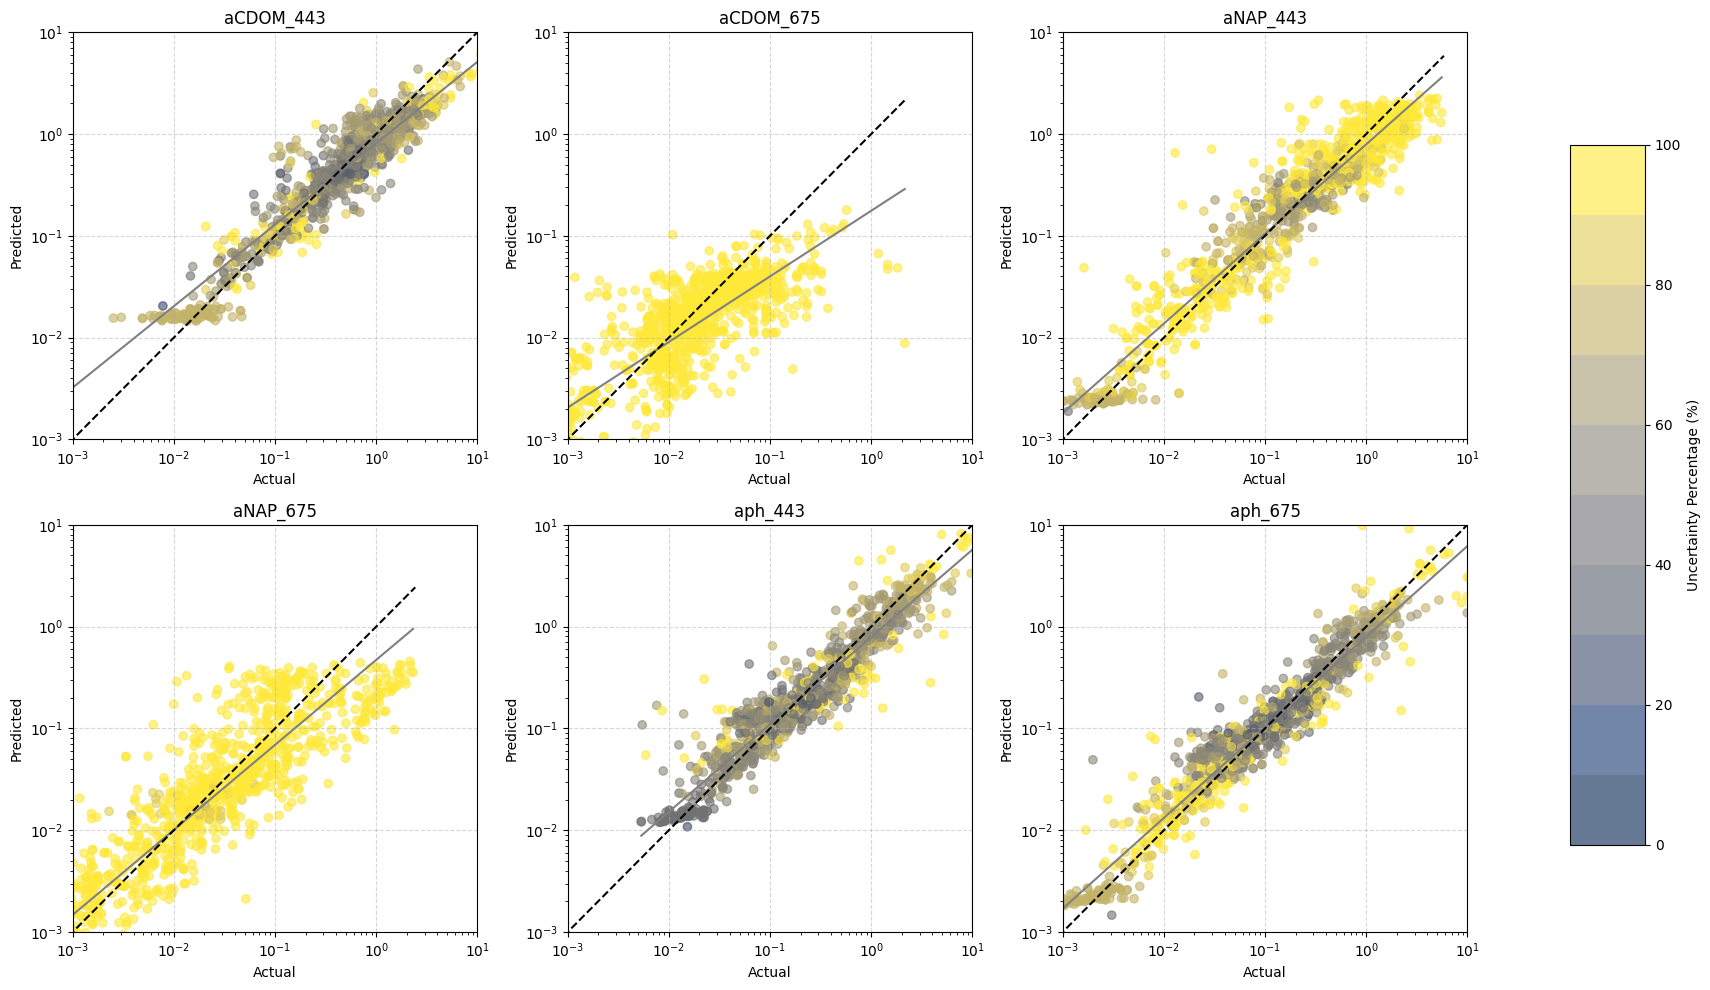

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=100)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap=plt.cm.cividis.resampled(10), norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)
        metrics_dict['MAD'].append(mad)
        metrics_dict['sspb'].append(sspb)
        metrics_dict['mdsa'].append(mdsa)

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)


In [ ]:
metrics_df

,obs_cor,MAPD,MAD,sspb,mdsa
aCDOM_443,1160,125.595951,0.463154,-9.477625,32.687191
aCDOM_675,1160,673.518865,1.111319,-18.822729,70.755880
aNAP_443,1160,63.747071,0.601980,-4.493883,43.784579
aNAP_675,1160,111.048745,1.020825,-2.879128,72.971488
aph_443,1160,53.505226,0.461376,2.290337,32.034200
aph_675,1160,48.029568,0.462004,4.196524,33.236814


# Estimate the 10 networks

In [ ]:
def build_bnn_mcd(input_shape, hidden_units=50, n_layers=5, dropout_rate=0.25, l2_reg=1e-3, activation='relu', output_size=6):
    model = Sequential()
    model.add(Dense(hidden_units, activation=activation, input_shape=input_shape, kernel_regularizer=l2(l2_reg)))
    for _ in range(n_layers - 1):
        model.add(Dropout(dropout_rate))
        model.add(Dense(hidden_units, activation=activation, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_size * 2, activation='linear'))
    return model

def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    log_var = y_pred[:, 6:]
    precision = tf.exp(-log_var)
    return tf.reduce_mean(0.5 * (log_var + tf.square(y_true - mean) * precision) + 0.5 * np.log(2 * np.pi))

def train_bnn_mcd(model, X_train, y_train, epochs=100, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=nll_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])
    return model

def predict_with_uncertainty(model, X, scaler_y, n_samples=100, mc_samples=2000):

    """
    Generate predictions with uncertainty estimates using Monte Carlo Dropout.

    This function performs forward passes through the model with dropout enabled to
    generate multiple predictions, then calculates the aleatoric and epistemic uncertainties
    of the predictions. It also scales the predictions back to the original scale to faciliate comparisons.

    Parameters:
    model: keras.Model
        The neural network model with dropout layers.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
    n_samples: int, optional (default=100)
        Number of forward passes with dropout to generate prediction samples.
    mc_samples: int, optional (default=2000)
        Number of Monte Carlo samples for back-scaling of variances.

    Returns:
    mean_predictions: np.ndarray
        The mean predictions on the original scale.
    total_variance_mc: np.ndarray
        The total variance (aleatoric + epistemic) on the original scale.
    aleatoric_variance_mc: np.ndarray
        The aleatoric variance on the original scale.
    epistemic_variance_mc: np.ndarray
        The epistemic variance on the original scale.
    std_devs_mc: np.ndarray
        The standard deviations of the predictions on the original scale.
    """

    pred_samples = [model.predict(X, batch_size=32, verbose=0) for _ in range(n_samples)]
    pred_samples = np.array(pred_samples)

    means = pred_samples[:, :, :6]
    log_variances = pred_samples[:, :, 6:]
    variances = np.exp(log_variances)  # Exponentiate log variances from the NLL loss function to get actual variances

    mean_predictions_scaled = np.mean(means, axis=0)
    aleatoric_variance_scaled = np.mean(variances, axis=0)
    epistemic_variance_scaled = np.var(means, axis=0)
    total_variance_scaled = aleatoric_variance_scaled + epistemic_variance_scaled

    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions = np.exp(mean_predictions_log)

    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2
    aleatoric_variance_log = aleatoric_variance_scaled * (scaling_factor ** 2)
    epistemic_variance_log = epistemic_variance_scaled * (scaling_factor ** 2)
    total_variance_log = total_variance_scaled * (scaling_factor ** 2)

    # Monte Carlo sampling for aleatoric variance
    aleatoric_samples = np.random.lognormal(mean_predictions_log, np.sqrt(aleatoric_variance_log), size=(mc_samples, *mean_predictions.shape))
    aleatoric_variance_mc = np.var(aleatoric_samples, axis=0)

    # Monte Carlo sampling for epistemic variance
    epistemic_samples = np.random.normal(mean_predictions, np.sqrt(epistemic_variance_log), size=(mc_samples, *mean_predictions.shape))
    epistemic_variance_mc = np.var(epistemic_samples, axis=0)

    total_variance_mc = aleatoric_variance_mc + epistemic_variance_mc
    std_devs_mc = np.sqrt(total_variance_mc)

    return mean_predictions, total_variance_mc, aleatoric_variance_mc, epistemic_variance_mc, std_devs_mc

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

def train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns, scaler_y,
                              input_shape, num_models=3, hidden_units=100, n_layers=5, dropout_rate=0.25,
                              l2_reg=1e-3, activation='relu', output_size=6,
                              epochs=1000, batch_size=32, learning_rate=0.001, n_samples=100):

    all_models = []
    all_mdsa = []

    best_overall_model = None
    min_total_mdsa = float('inf')

    for _ in range(num_models):
        model = build_bnn_mcd(input_shape=input_shape, hidden_units=hidden_units, n_layers=n_layers,
                              dropout_rate=dropout_rate, l2_reg=l2_reg, activation=activation, output_size=output_size)
        model = train_bnn_mcd(model, X_train, y_train_scaled, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

        print('Calculating mean_preds.')
        mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty(model, X_test, scaler_y, n_samples=100, mc_samples=2000)
        print('Completed predict with uncertainty.')
        print('Calculating metrics.')
        metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)

        all_models.append(model)
        all_mdsa.append(metrics_df['mdsa'].values)

        total_mdsa = metrics_df.loc[['aCDOM_443', 'aNAP_443', 'aph_443'], 'mdsa'].sum()  # Sum the mdsa of the specified variables
        if total_mdsa < min_total_mdsa:
            min_total_mdsa = total_mdsa
            best_overall_model = model

    mdsa_df = pd.DataFrame(all_mdsa, columns=y_columns)

    return best_overall_model, mdsa_df

#### starts here:

# Select Rrs values in 5 nm steps
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
Rrs_data = filtered_df[rrs_columns].values

# Apply Robust scaling to Rrs values
scaler_rrs = RobustScaler()
Rrs_data_scaled = scaler_rrs.fit_transform(Rrs_data)

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_data = filtered_df[y_columns].values

# Split the dataset into training and test sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(Rrs_data_scaled, y_data, test_size=0.5, random_state=43)

#Apply log transformation to the target variables
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#Apply Min-Max scaling to log-transformed target variables
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)

# Call
best_model, mdsa_df, mean_preds = train_and_evaluate_models(X_train, y_train_scaled, X_test, y_test, y_columns,scaler_y=scaler_y, input_shape = (X_train.shape[1],), num_models=10)

Epoch 1/1000
33/33 [==============================] - 2s 13ms/step - loss: 8.6028 - val_loss: 1.4074
Epoch 2/1000
33/33 [==============================] - 0s 5ms/step - loss: 1.4470 - val_loss: 1.1913
Epoch 3/1000
33/33 [==============================] - 0s 5ms/step - loss: 1.2638 - val_loss: 1.1403
Epoch 4/1000
33/33 [==============================] - 0s 5ms/step - loss: 1.1356 - val_loss: 1.0363
Epoch 5/1000
33/33 [==============================] - 0s 4ms/step - loss: 1.0988 - val_loss: 0.9814
Epoch 6/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.9962 - val_loss: 0.9057
Epoch 7/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.9099 - val_loss: 0.7679
Epoch 8/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.8342 - val_loss: 0.7613
Epoch 9/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.7994 - val_loss: 0.7263
Epoch 10/1000
33/33 [==============================] - 0s 4ms/step - loss: 0.7356 - val_loss: 0.593

In [ ]:
# refresh before saving - might time out
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
best_model

NameError: name 'best_model' is not defined

In [ ]:
mdsa_df

In [ ]:
# Saving the model
folder_path = '/content/drive/My Drive/iop_ml/best_models'
best_model.save(os.path.join(folder_path, 'bnn_mcd_random_split_best.h5'))

# Save MdSA of all models to a CSV file
mdsa_df.to_csv(os.path.join(folder_path, 'all_mdsa.csv'), index=False)
('Saved mdsa df.')

# Function to load the saved model
# def load_best_model(folder_path):
#     custom_objects = {'nll_loss': nll_loss}
#     return tf.keras.models.load_model(os.path.join(folder_path, 'best_model.h5'), custom_objects=custom_objects)

# Example of loading the model
#loaded_model = load_best_model(folder_path)


# MDN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from scipy.stats import linregress


# Select Rrs values in 5 nm steps
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
Rrs_data = filtered_df[rrs_columns].values

# Apply Robust scaling to Rrs values
scaler_rrs = RobustScaler()
Rrs_data_scaled = scaler_rrs.fit_transform(Rrs_data)

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_data = filtered_df[y_columns].values

# Split the dataset into training and test sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(Rrs_data_scaled, y_data, test_size=0.5, random_state=43)

#Apply log transformation to the target variables
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#Apply Min-Max scaling to log-transformed target variables
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)


In [ ]:
def custom_mdn_loss(num_components, num_targets, epsilon=1e-6):
    """

    The loss function computes the negative log likelihood of the true data given the predicted mixture distribution,
    which consists of a specified number of multivariate normal components. The NN outputs are split into
    mixing coefficients, means, and Cholesky decomposition parameters for the covariance matrices.

    Args:
        num_components (int): The number of mixture components (e.g., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space (e.g., the number of variables being predicted).
        epsilon (float, optional): Small value to ensure stability when constructing covariance matrices.
                                   Default is 1e-6.

    Returns:
        function: A loss function that can be used in model compilation.

    The returned loss function operates as follows:

    1. Splits the predicted values (`y_pred`) into mixing coefficients (`pi`), means (`mu`), and Cholesky decomposition
       parameters (`chol_params`).
    2. Applies a softmax function to the mixing coefficients to ensure they sum to 1.
    3. Reshapes the means and Cholesky decomposition parameters to the appropriate dimensions.
    4. Constructs the Cholesky lower triangular matrices from the Cholesky parameters.
    5. Adds `epsilon` to the diagonal elements of the Cholesky matrices to ensure positive definiteness.
    6. Defines a mixture of multivariate normal distributions using the reshaped parameters.
    7. Computes and returns the negative log likelihood of the true y given the mixture distribution (mix).

    Note:
          `num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)`.
    """
    def loss(y_true, y_pred):
        # Split y_pred into its components: mixing coefficients (pi), means (mu), and Cholesky decomposition parameters (chol_params)
        split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
        pi, mu, chol_params = tf.split(y_pred, num_or_size_splits=split_sizes, axis=-1)
        pi = tf.nn.softmax(pi, axis=-1)  # Softmax to get mixing coefficients

        # Reshape mu and chol_params to match the desired dimensions
        mu = tf.reshape(mu, [-1, num_components, num_targets])
        chol_params = tf.reshape(chol_params, [-1, num_components, num_targets * (num_targets + 1) // 2])

        # Create covariance matrices from the Cholesky parameters
        chol_matrices = tfp.math.fill_triangular(chol_params)
        # Ensure positive definiteness of covariance matrices
        chol_matrices += epsilon * tf.linalg.eye(num_targets, batch_shape=[tf.shape(y_pred)[0], num_components])

        # Define the mixture of Multivariate Normal distributions
        components = tfp.distributions.MultivariateNormalTriL(loc=mu, scale_tril=chol_matrices)
        mixture = tfp.distributions.Categorical(probs=pi)
        mix = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture, components_distribution=components)

        # Use mix: compute the log likelihood of the data given the model
        likelihood = mix.log_prob(y_true)

        # Return the negative log likelihood as the loss
        return -tf.reduce_mean(likelihood)

    return loss


In [ ]:
def build_mdn_wavelength_specific(input_shape, n_mix=5, hidden=[100, 100, 100, 100, 100], lr=1e-3, l2_reg=1e-3, activation='relu', num_targets=6):
    """
    Build the MDN.

    Args:
        input_shape (int): The shape of the input data.
        n_mix (int): The number of mixture components (default is 5).
        hidden (list): A list of integers specifying the number of units in each hidden layer (default is [100, 100, 100, 100, 100]).
        lr (float): The learning rate for the optimizer (default is 1e-3).
        l2_reg (float): The L2 regularization factor (default is 1e-3).
        activation (str): The activation function to use in the hidden layers (default is 'relu').
        num_targets (int): The dimensionality of the target space (default is 6).

    Returns:
        Model: ready for training.
    """
    inputs = Input(shape=(input_shape,))
    x = inputs
    for units in hidden:
        x = Dense(units, activation=activation, kernel_regularizer=l2(l2_reg))(x)
    pi = Dense(n_mix, activation='softmax', name='pi')(x)
    mu = Dense(n_mix * num_targets, activation=None, name='mu')(x)

    # Calculate the size for Cholesky decomposition parameters
    chol_size = n_mix * num_targets * (num_targets + 1) // 2
    chol_params = Dense(chol_size, activation=None, name='chol')(x)

    outputs = Concatenate(axis=-1)([pi, mu, chol_params])

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Pass the correct parameters to the custom MDN loss function
    mdn_loss = custom_mdn_loss(n_mix, num_targets)
    model.compile(optimizer=optimizer, loss=mdn_loss)
    return model


In [ ]:
def train_mdn(model, X_train, y_train, epochs=100, batch_size=32):
    """
    Train the MDN.

    Args:
        model (Model): The MDN model to be trained.
        X_train (np.ndarray): The training input data.
        y_train (np.ndarray): The training target data.
        epochs (int): The number of epochs to train the model (default is 100).
        batch_size (int): The size of the training batches (default is 32).

    Returns:
        Model, training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    # Fit the model with a validation split of 10%
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

    return model, history


In [ ]:
# Define the number of mixture components and target variables
n_mix = 5
num_targets = 6

# Build the MDN
model = build_mdn_wavelength_specific(input_shape=X_train.shape[1], n_mix=n_mix, hidden=[100, 100, 100, 100, 100], lr=1e-3, l2_reg=1e-3, activation='relu', num_targets=num_targets)

# Train the MDN
mdn_model, mdn_hist = train_mdn(model, X_train, y_train_scaled, epochs=500, batch_size=32)


Epoch 1/500
33/33 [==============================] - 4s 25ms/step - loss: 1274.8892 - val_loss: 23.1425
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 21.2724 - val_loss: 12.6401
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 9.2300 - val_loss: 5.2942
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 3.7222 - val_loss: 3.6746
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 2.7108 - val_loss: 3.0023
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 1.8842 - val_loss: 2.0776
Epoch 7/500
33/33 [==============================] - 0s 5ms/step - loss: 1.0336 - val_loss: 1.2243
Epoch 8/500
33/33 [==============================] - 0s 5ms/step - loss: 0.3223 - val_loss: 0.5387
Epoch 9/500
33/33 [==============================] - 0s 5ms/step - loss: -0.3415 - val_loss: -0.1019
Epoch 10/500
33/33 [==============================] - 0s 5ms/step - loss: -0.7743 - val_loss: -0.504

In [ ]:
# Generate preds
raw_predictions = mdn_model.predict(X_test)

n_mix = 5  # Number of mixture components
num_targets = 6  # Number of target variables

def split_mdn_outputs(raw_predictions, num_components, num_targets):
    """
    Split the raw prdictions into pi, mu and chol parameters.

    Args:
        raw_predictions (tf.Tensor): The raw output from the MDN model, with shape [batch_size, num_components * (1 + num_targets + num_targets * (num_targets + 1) // 2)].
        num_components (int): The number of mixture components (i.e., the number of Gaussian distributions in the mixture).
        num_targets (int): The dimensionality of the target space.

    Returns:
        pi (tf.Tensor): The mixing coefficients for each component, with shape [batch_size, num_components].
        mu (tf.Tensor): The means of the Gaussian components, with shape [batch_size, num_components, num_targets].
        chol_params (tf.Tensor): The Cholesky decomposition parameters for the covariance matrices of the Gaussian components, with shape [batch_size, num_components, num_targets * (num_targets + 1) // 2].

    The function operates as follows:

    1. Splits the `raw_predictions` tensor into three parts:
       - `pi`: Mixing coefficients of shape [batch_size, num_components].
       - `mu`: Means of shape [batch_size, num_components * num_targets].
       - `chol_params`: Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
    2. Applies a softmax function to `pi` to ensure the mixing coefficients sum to 1.
    3. Reshapes `mu` to [batch_size, num_components, num_targets].
    4. Reshapes `chol_params` to [batch_size, num_components, num_targets * (num_targets + 1) // 2].
    """
    split_sizes = [num_components, num_components * num_targets, num_components * num_targets * (num_targets + 1) // 2]
    pi, mu, chol_params = tf.split(raw_predictions, num_or_size_splits=split_sizes, axis=-1)
    pi = tf.nn.softmax(pi, axis=-1)  # Ensure mixing coefficients sum to 1
    return pi, mu, chol_params

# Apply
pi, mu, chol_params = split_mdn_outputs(raw_predictions, n_mix, num_targets)


37/37 [==============================] - 0s 2ms/step


In [ ]:
def mdn_total_uncertainty(pi, mu, chol_params, num_components, num_targets, scaler_y):
    """
    Calculate the mean predictions, aleatoric variance, epistemic variance, and total variance for the MDN.

    Args:
        pi (tf.Tensor): Mixing coefficients of shape [batch_size, num_components].
        mu (tf.Tensor): Means of the mixture components of shape [batch_size, num_components * num_targets].
        chol_params (tf.Tensor): Cholesky decomposition parameters of shape [batch_size, num_components * num_targets * (num_targets + 1) // 2].
        num_components (int): The number of mixture components.
        num_targets (int): The dimensionality of the target space.
        scaler_y (sklearn.preprocessing.MinMaxScaler): Scaler used to transform the target variables.

    Returns:
        mean_predictions (np.ndarray): Mean predictions in the original space of shape [batch_size, num_targets].
        total_variance (np.ndarray): Total variance in the original space of shape.
        aleatoric_variance (np.ndarray): Aleatoric variance in the original space.
        epistemic_variance (np.ndarray): Epistemic variance in the original space.
        std_devs (np.ndarray): Standard deviations in the original space.
    """
    # Reshape pi and mu
    pi = tf.reshape(pi, [-1, num_components, 1])
    mu = tf.reshape(mu, [-1, num_components, num_targets])

    # Calculate the mean predictions (expected means)
    mean_predictions = tf.reduce_sum(pi * mu, axis=1)  # mean_predictions shape: [batch_size, num_targets]

    # Reshape chol_params and calculate Sigma
    chol_elements = num_targets * (num_targets + 1) // 2
    chol_matrices = tf.reshape(chol_params, [-1, num_components, chol_elements])
    L = tfp.math.fill_triangular(chol_matrices)
    Sigma = tf.matmul(L, L, transpose_b=True)  # [batch_size, num_components, num_targets, num_targets]

    # Aleatoric var
    variances = tf.linalg.diag_part(Sigma)  # [batch_size, num_components, num_targets]
    aleatoric_variance = tf.reduce_sum(pi * variances, axis=1)  # [batch_size, num_targets]

    # Epistemic var
    mu_weighted = pi * mu  # Weight means by their mixture probabilities
    mu_squared_weighted = pi * tf.square(mu)  # Weight squared means by their mixture probabilities
    expected_mu_squared = tf.reduce_sum(mu_squared_weighted, axis=1)  # [batch_size, num_targets]
    square_of_expected_mu = tf.square(tf.reduce_sum(mu_weighted, axis=1))  # [batch_size, num_targets]
    epistemic_variance = expected_mu_squared - square_of_expected_mu  # [batch_size, num_targets]

    # Total var
    total_variance = aleatoric_variance + epistemic_variance  # [batch_size, num_targets]
    ale_frac = aleatoric_variance / total_variance

    # Reshape mean predictions for inverse transformation
    original_shape = mean_predictions.shape
    mean_predictions_scaled = mean_predictions.numpy().reshape(-1, num_targets)

    # Convert means from scaled space to log space
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    # Calculate the scaling factor for variances
    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log->scaled scaling factor

    # Back-scale the variances
    #aleatoric_variance = aleatoric_variance * (scaling_factor ** 2)
    #epistemic_variance = epistemic_variance * (scaling_factor ** 2)
    total_variance = total_variance * (scaling_factor ** 2)

    # Convert from log space to the original space
    mean_predictions = np.exp(mean_predictions_log)
    #aleatoric_variance = np.exp(2 * mean_predictions_log + aleatoric_variance) * (np.exp(aleatoric_variance) - 1)
    #epistemic_variance = np.exp(2 * mean_predictions_log + epistemic_variance) * (np.exp(epistemic_variance) - 1)
    #total_variance = aleatoric_variance + epistemic_variance
    total_variance = np.exp(2 * mean_predictions_log + total_variance) * (np.exp(total_variance) - 1)
    aleatoric_variance = ale_frac * total_variance
    epistemic_variance = (1-ale_frac) * total_variance

    # Calculate standard deviations
    std_devs = np.sqrt(total_variance)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs


In [ ]:
mean_preds, total_var, alea_var, epi_var, std_devs = mdn_total_uncertainty(pi, mu, chol_params, 5, 6, scaler_y=scaler_y)

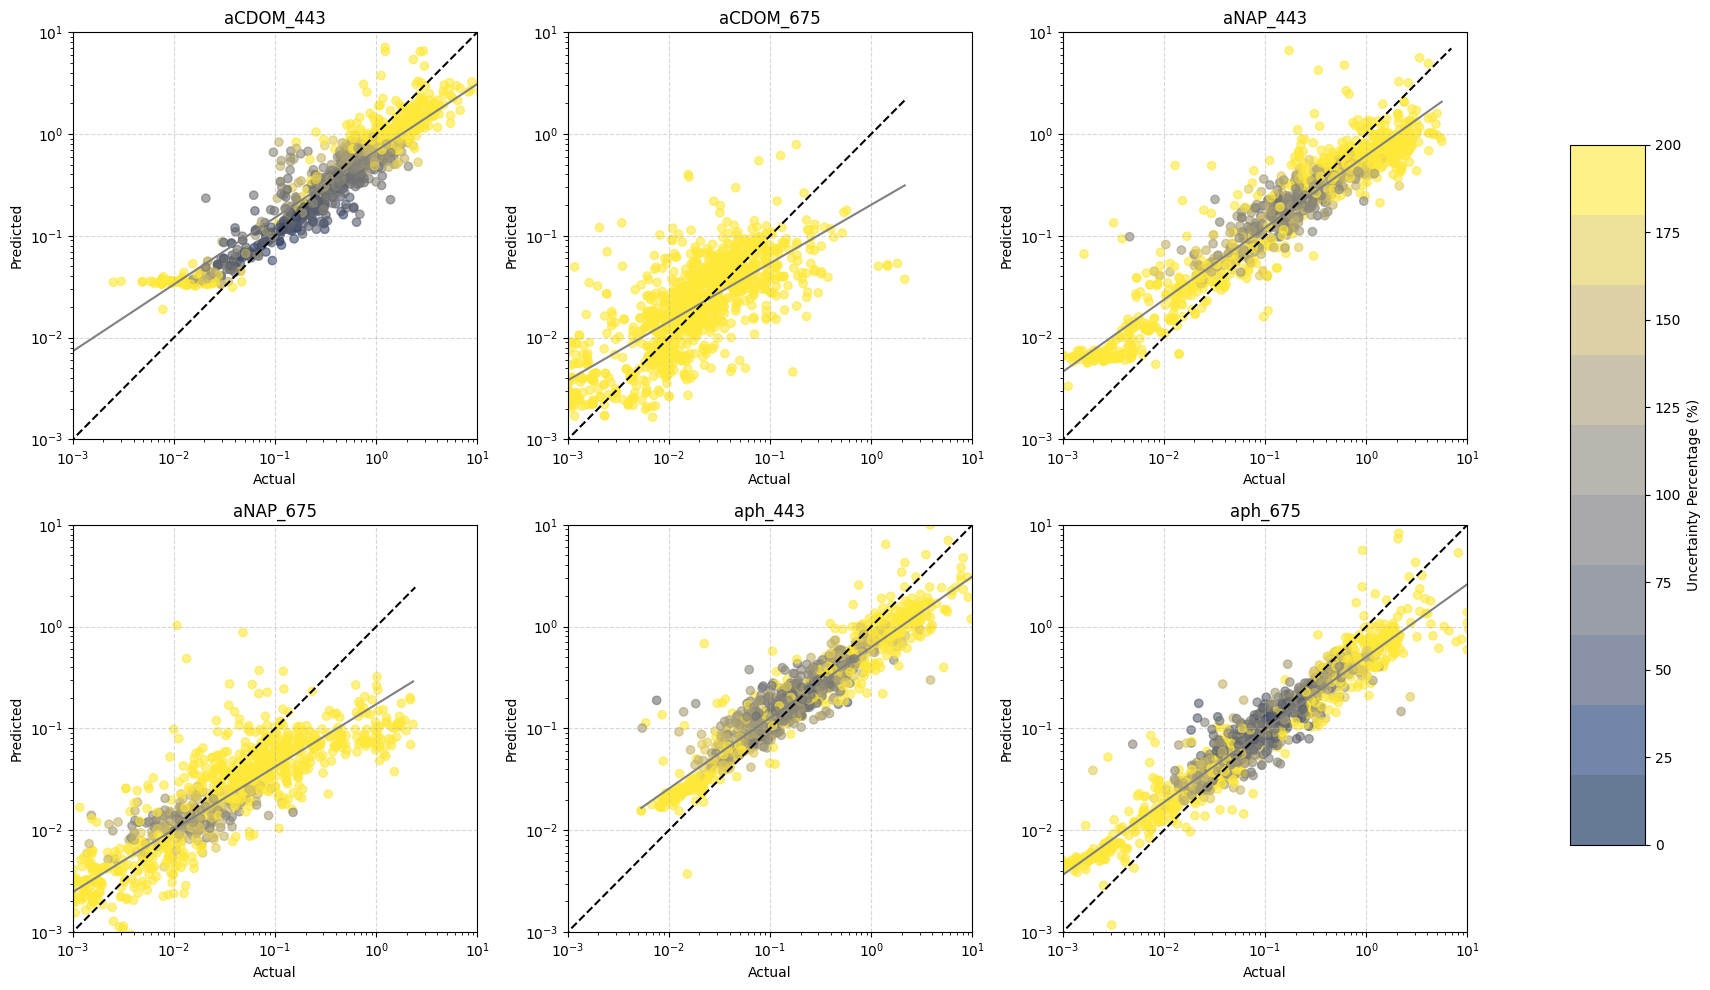

In [ ]:
# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(alea_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epi_var) / mean_preds) * 100

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 200]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap=plt.cm.cividis.resampled(10), norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')

    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

plt.tight_layout()

cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

plt.show()


In [ ]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

def calculate_and_store_metrics(y_test, mean_preds, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(y_test.shape[1]):
        y_true = y_test[:, i]
        y_pred = mean_preds[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)
        metrics_dict['MAD'].append(mad)
        metrics_dict['sspb'].append(sspb)
        metrics_dict['mdsa'].append(mdsa)

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)


In [ ]:
metrics_df

,obs_cor,MAPD,MAD,sspb,mdsa
aCDOM_443,1160,277.063153,0.436332,-12.564819,28.016715
aCDOM_675,1160,1498.756313,1.076424,-5.081619,64.276999
aNAP_443,1160,63.458600,0.623965,-9.309293,47.463847
aNAP_675,1160,90.738915,0.989835,-3.145626,69.547151
aph_443,1160,49.252289,0.443334,-10.659679,29.721001
aph_675,1160,44.702992,0.430594,-2.306348,27.705682
